# Домашнее задание 5. Линейная регрессия и метод наименьших квадратов
Ковалев Даниил, СКБ171

In [2]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import os
from scipy import special, stats
from scipy.stats import pearsonr, mstats
from bisect import bisect_left, bisect_right
import functools
%matplotlib inline

Хотим восстановить функциональную зависимость $y(x)=ax+b$. Поиск оценок коэффициентов $\hat{a}$ и $\hat{b}$ будем осуществлять методом наименьших квадратов, то есть минимизируя сумму квадратов отклонений:

$E(\hat{a},\hat{b})=\sum\limits_{i=1}^{n}\left(\hat{a}x_i+\hat{b}-y_i\right)^2$

Необходимое условие экстремума функции $E(\hat{a},\hat{b})$: частные производные по $\hat{a}$ и $\hat{b}$ равны нулю:

$\begin{cases}
\dfrac{\partial E(\hat{a},\hat{b})}{\partial \hat{a}}=0,\\
\dfrac{\partial E(\hat{a},\hat{b})}{\partial \hat{b}}=0
\end{cases}\Leftrightarrow
\begin{cases}
2\sum\limits_{i=1}^{n}\left[\left(\hat{a}x_i+\hat{b}-y_i\right)\cdot x_i\right]=0,\\
2\sum\limits_{i=1}^{n}\left(\hat{a}x_i+\hat{b}-y_i\right)=0
\end{cases}\Leftrightarrow
\begin{cases}
\hat{a}\sum\limits_{i=1}^{n}x_i^2+\hat{b}\sum\limits_{i=1}^{n}x_i=\sum\limits_{i=1}^{n}x_i y_i,\\
\hat{a}\sum\limits_{i=1}^{n}x_i+\hat{b}n=\sum\limits_{i=1}^{n}y_i
\end{cases}$

Получим значение $\hat{a}$ методом Крамера:

$\Delta=
\begin{vmatrix}
\sum\limits_{i=1}^{n}x_i^2& \sum\limits_{i=1}^{n}x_i\\
\sum\limits_{i=1}^{n}x_i& n
\end{vmatrix}=n\sum\limits_{i=1}^{n}x_i^2 - \left(\sum\limits_{i=1}^{n}x_i\right)^2$

$\Delta_{\hat{a}}=
\begin{vmatrix}
\sum\limits_{i=1}^{n}x_i y_i& \sum\limits_{i=1}^{n}x_i\\
\sum\limits_{i=1}^{n}y_i& n
\end{vmatrix}=n\sum\limits_{i=1}^{n}x_i y_i - \sum\limits_{i=1}^{n}x_i \sum\limits_{i=1}^{n}y_i$

$\hat{a}=\dfrac{\Delta_{\hat{a}}}{\Delta}=
\dfrac{n\sum\limits_{i=1}^{n}x_i y_i - \sum\limits_{i=1}^{n}x_i \sum\limits_{i=1}^{n}y_i}{n\sum\limits_{i=1}^{n}x_i^2 - \left(\sum\limits_{i=1}^{n}x_i\right)^2}$

Значение $\hat{b}$ выразим из второго уравнения через $\hat{a}$:

$\hat{b}=\dfrac{\sum\limits_{i=1}^{n}y_i-\hat{a}\sum\limits_{i=1}^{n}x_i}{n}$

Проверим, что найденная точка $\left(\hat{a},\hat{b}\right)$ действительно является экстремумом функции $E$, а именно, точкой локального минимума.

$A=E^{''}_{\hat{a}\hat{a}}=2\sum\limits_{i=1}^{n}x_i^2$

$B=E^{''}_{\hat{a}\hat{b}}=2\sum\limits_{i=1}^{n}x_i$

$C=E^{''}_{\hat{b}\hat{b}}=2n$

$AC-B^2=4n\sum\limits_{i=1}^{n}x_i^2-4\left(\sum\limits_{i=1}^{n}x_i\right)^2>0$ (следует из неравенства Коши-Буняковского), значит, $\left(\hat{a},\hat{b}\right)$ - точка экстремума функции $E$. Кроме того, $C=2n>0$, следовательно, она является точкой локального минимума.

Итак, оптимальные коэффициенты линейной регрессии, согласно МНК, можно найти по формулам:

$\hat{a}=\dfrac{n\sum\limits_{i=1}^{n}x_i y_i - \sum\limits_{i=1}^{n}x_i \sum\limits_{i=1}^{n}y_i}{n\sum\limits_{i=1}^{n}x_i^2 - \left(\sum\limits_{i=1}^{n}x_i\right)^2}$

$\hat{b}=\dfrac{\sum\limits_{i=1}^{n}y_i-\hat{a}\sum\limits_{i=1}^{n}x_i}{n}$

Для проверки данных на степень линейной зависимости напишем функцию, считающую коэффициент корреляции Пирсона по формуле:

$r_{xy}=\dfrac{\sum\limits_{i=1}^{n}\left(x_i-\overline{x}\right)\left(y_i-\overline{y}\right)}
{\sqrt{\sum\limits_{i=1}^{n}\left(x_i-\overline{x}\right)^2 \sum\limits_{i=1}^{n}\left(y_i-\overline{y}\right)^2}}$,

где $x^n=\left(x_1,\ldots,x_n\right)$, $y^n=\left(y_1,\ldots,y_n\right)$ - выборки

In [22]:
def pearson_coeff(x, y):
    if x.shape != y.shape:
        raise ValueError("Samples x and y must have the same shape")
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    cov = np.sum((x-x_mean) * (y-y_mean))
    s2_x = np.sum((x - x_mean) ** 2)
    s2_y = np.sum((y - y_mean) ** 2)
    return cov / np.sqrt(s2_x * s2_y)

In [24]:
def find_regression_coeffs(x, y):
    if x.shape != y.shape:
        raise ValueError("Samples x and y must have the same shape")
    n = x.shape[0]
    a_num = n * np.sum(x * y) - np.sum(x) * np.sum(y)
    a_den = n * np.sum(x ** 2) - (np.sum(x)) ** 2
    a = a_num / a_den
    b = (np.sum(y) - a * np.sum(x)) / n
    return a, b

## Работа с данными

Взяли данные о курсе рубля и курса фьючерса на нефть Brent с 1 января 2002 по 1 января 2008 [1] [2].

In [118]:
rub_data = pd.read_csv("usd_rub.csv", index_col="Дата")
oil_data = pd.read_csv("oil.csv", index_col="Дата")

Т.к. на биржах, на которых производятся торги, иногда бывают разные выходные, нужно "вычленить" одинаковые даты

In [121]:
common_dates = oil_data.index.intersection(rub_data.index)
oil_data = oil_data.loc[common_dates]
rub_data = rub_data.loc[common_dates]

Выбираем из данных цену, приводим к нужному формату

In [122]:
oil_cost = oil_data['Цена'].str.replace(',', '.').astype('float64')
rub_cost = rub_data['Цена'].str.replace(',', '.').astype('float64')

Считаем коэффициент корреляции:

In [123]:
pearson_coeff(oil_cost, rub_cost)

-0.9005113233929095

Итак, доллар по отношению к рублю тем дешевле, чем выше цена на нефть.

Найдем коэффициенты корреляции и отобразим данные и аппроксимирующую прямую на графике.

In [133]:
a, b = find_regression_coeffs(oil_cost, rub_cost)
print((a, b))

(-0.09550585485457527, 33.19646797317683)


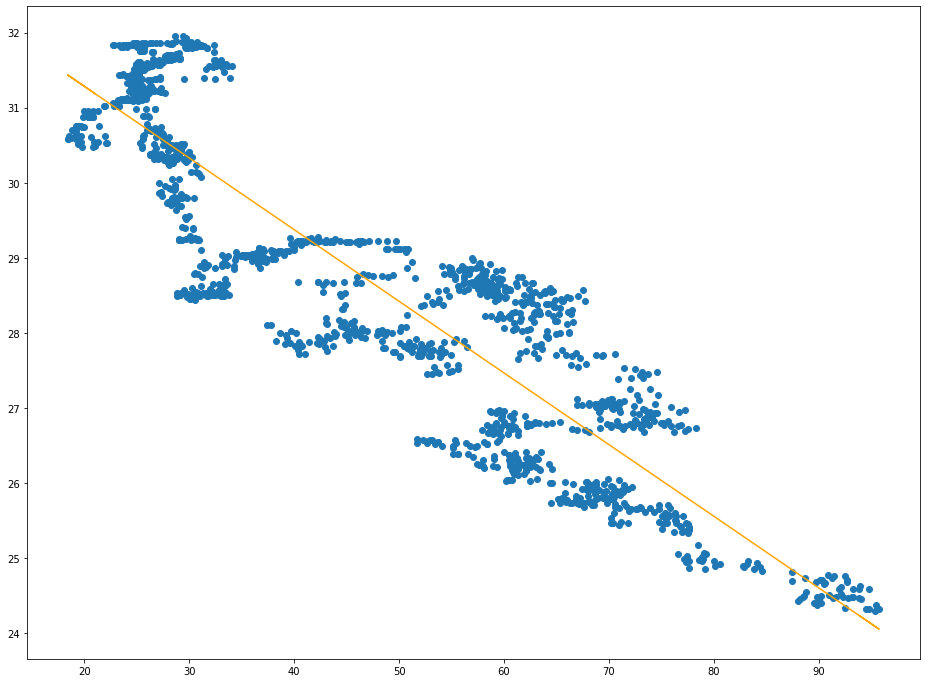

In [134]:
x, y = oil_cost, rub_cost
plt.figure(figsize=(16, 12))
plt.scatter(x, y)
plt.plot(x, a * x + b, color='orange')
plt.show()

## Источники

[1] Прошлые данные - USD/RUB. URL: https://ru.investing.com/currencies/usd-rub-historical-data

[2] Прошлые данные - Фьючерс на нефть Brent. URL: https://ru.investing.com/commodities/brent-oil-historical-data